# Implementing an equation of state in python

> In `FeOs`, you can implement your equation of state in python, register it to the Rust backend, and compute properties and phase equilbria as if you implemented it in Rust.
> In this tutorial, we will implement the Peng-Robinson equation of state.

## Table of contents <a id="toc"/>

- [Setup](#setup)
- [Implementation](#implementation)
- [Computing properties](#props)
- [Critical point](#crit)
- [Phase equilibria and phase diagrams](#vle)
- [Mixtures](#mix)
- [Comparison to Rust implementation](#rust)

## Setup <a id="setup"/>
[↑ Back to top](#toc)

Let's start by importing the necessary python packages. Mandatory packages are

- `feos_core.user_defined` for classes such as `State`, `PhaseEquilibrium`, and `UserDefinedEos`,
- `feos_core.si` for SI numbers,
- `numpy` for multidimensional arrays.

We also recommend using

- `matplotlib` and `seaborn` for visualization, and
- `pandas` for easier data handling.

If you don't want to use the optional packages, simply remove them from the import statement below or set `optional = False`.

In [1]:
from feos_core.user_defined import *
from feos_core.si import *
import numpy as np

optional = True

if optional:
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    sns.set_style("ticks")
    sns.set_palette("Dark2")
    sns.set_context("talk")

## Implementation <a id="implementation"/>
[↑ Back to top](#toc)

To implement an equation of state in python, we have to define a `class` which has to have the following methods:

```python
class EquationOfState:
    def helmholtz_energy(self, state: StateHD) -> D
    
    def components(self) -> int
    
    def subset(self, indices: List[int]) -> Self
    
    def molar_weight(self) -> SIArray1
    
    def max_density(self, moles: SIArray1) -> f64
```    

- `components(self) -> int`: Returns the number of components (usually inferred from the shape of the input parameters).
- `molar_weight(self) -> SIArray1`: Returns an `SIArray1` with size equal to the number of components containing the molar mass of each component.
- `max_density(self, moles: np.ndarray[float]) -> float`: Returns the maximum allowed number density in units of `molecules/Angstrom³`.
- `subset(self, indices: List[int]) -> self`: Returns a new equation of state for the components defined in `indices`.
- `helmholtz_energy(self, state: StateHD) -> Dual`: Returns the helmholtz energy as (hyper)-dual number given a `StateHD`.

In [2]:
SQRT2 = np.sqrt(2)

class PyPengRobinson: 
    def __init__(self, critical_temperature, critical_pressure, acentric_factor, molar_weight, delta_ij=None):
        """Peng-Robinson Equation of State
        
        Parameters
        ----------
        critical_temperature : SIArray1
            critical temperature of each component.
        critical_pressure : SIArray1
            critical pressure of each component.
        acentric_factor : np.array[float] 
            acentric factor of each component (dimensionless).
        molar_weight: SIArray1
            molar weight of each component.
        delta_ij : np.array[[float]], optional
            binary parameters. Shape=[n, n], n = number of components.
            defaults to zero for all binary interactions.
            
        Raises
        ------
        ValueError: if the input values have incompatible sizes.
        """
        self.n = len(critical_temperature)
        if len(set((len(critical_temperature), len(critical_pressure), len(acentric_factor)))) != 1:
            raise ValueError("Input parameters must all have the same lenght.")
        
        self.tc = critical_temperature
        self.pc = critical_pressure
        self.omega = acentric_factor
        self.mw = molar_weight
        
        self.a_r = 0.45724 * critical_temperature**2 * RGAS / critical_pressure / ANGSTROM**3 / NAV / KELVIN
        self.b = 0.07780 * critical_temperature * RGAS / critical_pressure / ANGSTROM**3 / NAV
        self.kappa = 0.37464 + (1.54226 - 0.26992 * acentric_factor) * acentric_factor
        self.delta_ij = np.zeros((self.n, self.n)) if delta_ij is None else delta_ij
        
    def helmholtz_energy(self, state):
        """Return helmholtz energy.
        
        Parameters
        ----------
        state : StateHD
            The thermodynamic state.
            
        Returns
        -------
        helmholtz_energy: float | any dual number
            The return type depends on the input types.
        """      
        n = np.sum(state.moles)
        x = state.molefracs
        tr = KELVIN / self.tc * state.temperature
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        if self.n > 1:
            for i in range(self.n):
                for j in range(self.n):
                    ak_mix += np.sqrt(ak[i] * ak[j]) * (x[i] * x[j] * (1.0 - self.delta_ij[i, j]))
        else:
            ak_mix = ak[0]
        b = np.sum(x * self.b)
        v = state.volume
        return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature) 
                    * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))
    
    def components(self) -> int: 
        """Number of components."""
        return self.n
    
    def subset(self, indices: [int]):
        """Return new equation of state containing a subset of all components.""" 
        tc = SIArray1([self.tc[i] for i in indices])
        pc = SIArray1([self.pc[i] for i in indices])
        mw = SIArray1([self.mw[i] for i in indices])
        omega = self.omega[indices]
        return PyPengRobinson(tc, pc, omega, mw)
        
    def molar_weight(self) -> SIArray1:
        return self.mw
    
    def max_density(self, moles:[float]) -> float:
        b = np.sum(moles * self.b) / np.sum(moles);
        return 0.9 / b 

## Computing properties <a id="props"/>
[↑ Back to top](#toc)

Let's compute some properties. First, we have to instantiate the class and register it to Rust.
This is done using the `UserDefinedEos` class.

In [3]:
# parameters for propane
tc = SIArray1(369.96 * KELVIN)
pc = SIArray1(4250000.0 * PASCAL)
omega = np.array([0.153])
molar_weight = SIArray1(44.0962 * GRAM / MOL)

# create an instance of our python class and hand it over to rust
eos = UserDefinedEos(PyPengRobinson(tc, pc, omega, molar_weight))

### Thermodynamic state

Before we can compute a property, we create a `State` object. This can be done in several ways depending on what control variables we need.
If no total amount of substance is defined, it is set to $n = \frac{1}{N_{AV}}$.
For possible input combinations, you can inspect the signature of the constructor using `State?`.

In [4]:
State?

Init signature: State(self, /, *args, **kwargs)
Docstring:     
A thermodynamic state at given conditions.

Parameters
----------
eos : Eos
    The equation of state to use.
temperature : SINumber, optional
    Temperature.
volume : SINumber, optional
    Volume.
density : SINumber, optional
    Molar density.
partial_density : SIArray1, optional
    Partial molar densities.
total_moles : SINumber, optional
    Total amount of substance (of a mixture).
moles : SIArray1, optional
    Amount of substance for each component.
molefracs : numpy.ndarray[float]
    Molar fraction of each component.
pressure : SINumber, optional
    System pressure.
enthalpy : SINumber, optional
    System enthalpy.
entropy : SINumber, optional
    System entropy.
density_initialization : {'vapor', 'liquid', SINumber, None}, optional
    Method used to initialize density for density iteration.
    'vapor' and 'liquid' are inferred from the maximum density of the equation of state.
    If no density or keyword 

If we use input variables other than $\mathbf{N}, V, T$ (the natural variables of the Helmholtz energy), creating a state is an iterative procedure.
For example, we can create a state for a give $T, p$, which will result in a iteration of the volume (density).

In [5]:
# If no amount of substance is given, it is set to 1/NAV.
s = State(eos, temperature=300*KELVIN, pressure=1*BAR)
s.total_moles

1.6605390671738466e-24 mol

In [6]:
s_pt = State(eos, temperature=300*KELVIN, pressure=1*BAR, total_moles=1*MOL)
s_pt.total_moles

1  mol

We can use other variables as well. For example, we can create a state at given $h, p$ (using the enthalpy from the prior computation as input):

In [7]:
h = s.molar_enthalpy()
s_ph = State(eos, pressure=1*BAR, enthalpy=s_pt.molar_enthalpy())

In [8]:
# check if states are equal
print("rel. dev.")
print("entropy    : ", (s_ph.molar_entropy() - s_pt.molar_entropy()) / s_pt.molar_entropy())
print("density    : ", (s_ph.mass_density() - s_pt.mass_density()) / s_pt.mass_density())
print("temperature: ", (s_ph.temperature - s_pt.temperature) / s_pt.temperature)

rel. dev.
entropy    :  -2.405775647837077e-16
density    :  -2.4710632058670096e-15
temperature:  3.031649005909761e-15


## Critical point <a id="crit"/>
[↑ Back to top](#toc)

To generate a state at critical conditions, we can use the `critical_point` constructor.

In [9]:
s_cp = State.critical_point(eos)
print("Critical point")
print("temperature: ", s_cp.temperature)
print("density    : ", s_cp.mass_density())
print("pressure   : ", s_cp.pressure())

Critical point
temperature:  369.95061742346076 K
density    :  198.18624580571773 kg/m³
pressure   :  4.249677749116942 MPa


## Phase equilibria and phase diagrams<a id="vle"/>
[↑ Back to top](#toc)

We can also create an object, `PhaseEquilibrium`, that contains states that are in equilibrium.

In [10]:
vle = PhaseEquilibrium.pure_t(eos, temperature=350*KELVIN)
vle

/tmp/ipykernel_11471/2221081275.py:65: RuntimeWarning: invalid value encountered in log
  return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature)


||temperature|density|
|-|-|-|
|phase 1|350.00000 K|1.78858 kmol/m³|
|phase 2|350.00000 K|8.19034 kmol/m³|


Each phase is a `State` object. We can simply access these states and compute properties, just like before.

In [11]:
vle.liquid # the high density phase `State`

|temperature|density|
|-|-|
|350.00000 K|8.19034 kmol/m³|

In [12]:
vle.vapor # the low density phase `State`

|temperature|density|
|-|-|
|350.00000 K|1.78858 kmol/m³|

In [13]:
# we can now easily compute any property:
print("Heat of vaporization: ", vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy())
print("for T = {}".format(vle.liquid.temperature))
print("and p = {:.2f} bar".format(vle.liquid.pressure() / BAR))

Heat of vaporization:  8.591742172312552 kJ/mol
for T = 350 K
and p = 29.63 bar


We can also easily compute **vapor pressures** and **boiling temperatures**:

In [14]:
# This also works for mixtures, in which case the pure component properties are computed.
# Hence, the result is a list - that is why we use an index [0] here.
print("vapor pressure      (T = 300 K):", PhaseEquilibrium.vapor_pressure(eos, 300*KELVIN)[0])
print("boiling temperature (p = 3 bar):", PhaseEquilibrium.boiling_temperature(eos, 2*BAR)[0])

vapor pressure      (T = 300 K): 994.7761635610093 kPa
boiling temperature (p = 3 bar): 247.8403557495675 K


/tmp/ipykernel_11471/2221081275.py:65: RuntimeWarning: invalid value encountered in log
  return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature)
/tmp/ipykernel_11471/2221081275.py:66: RuntimeWarning: invalid value encountered in log
  * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))


### Phase Diagram

We could repeatedly compute `PhaseEquilibrium` states for different temperatures / pressures to generate a phase diagram.
Because this a common task, there is a object for that as well.

The `PhaseDiagramPure` object creates multiple `PhaseEquilibrium` objects (`npoints`) between a given lower temperature and the critical point.

In [15]:
dia = PhaseDiagramPure(eos, 250.0 * KELVIN, 500)

/tmp/ipykernel_11471/2221081275.py:65: RuntimeWarning: invalid value encountered in log
  return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature)
/tmp/ipykernel_11471/2221081275.py:66: RuntimeWarning: invalid value encountered in log
  * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))


We can have access to each `PhaseEquilbrium` and can conveniently compute any property we like:

In [16]:
enthalpy_of_vaporization = [(vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy()) / (KILO * JOULE) * MOL for vle in dia.states]

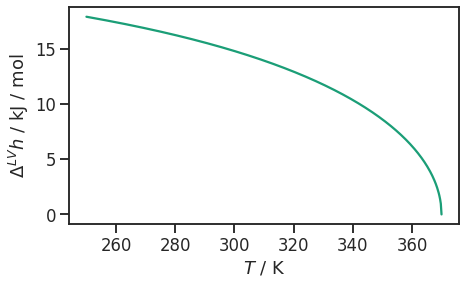

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(x=dia.temperature / KELVIN, y=enthalpy_of_vaporization, ax=ax);
ax.set_ylabel(r"$\Delta^{LV}h$ / kJ / mol")
ax.set_xlabel(r"$T$ / K");

A more convenient way is to create a dictionary. The dictionary can conveniently be used with pandas dataframe objects.
This is a bit less flexible, because the units of the properties are rigid. You can inspect the method signature to check what units are used.

In [18]:
dia.to_dict?

Docstring:
Returns the phase diagram as dictionary.

Note
----
temperature : K
pressure : Pa
densities : mol / m³
molar enthalpies : kJ / mol
molar entropies : kJ / mol / K

Returns
-------
dict[str, list[float]]
    Keys: property names. Values: property for each state.
Type:      builtin_function_or_method


In [19]:
data_dia = pd.DataFrame(dia.to_dict())
data_dia.head()

,molar enthalpy liquid,temperature,molar entropy liquid,molar enthalpy vapor,molar entropy vapor,pressure,density vapor,density liquid
0,3.888854,250.000000,0.041205,21.774512,0.112747,216751.867612,110.874504,13517.744128
1,3.895457,250.240382,0.041231,21.769636,0.112659,218680.955365,111.801129,13509.916346
2,3.902072,250.480764,0.041256,21.764747,0.112570,220623.177946,112.733771,13502.075331
3,3.908698,250.721146,0.041282,21.759845,0.112481,222578.594255,113.672458,13494.221046
4,3.915336,250.961528,0.041308,21.754930,0.112393,224547.263292,114.617219,13486.353455


Once we have a dataframe, we can store our results or create a nicely looking plot:

In [20]:
def phase_plot(data, x, y):
    fig, ax = plt.subplots(figsize=(12, 6))
    if x != "pressure" and x != "temperature":
        xl = f"{x} liquid"
        xv = f"{x} vapor"
    else:
        xl = x
        xv = x
    if y != "pressure" and y != "temperature":
        yl = f"{y} liquid"
        yv = f"{y} vapor"
    else:
        yv = y
        yl = y
    sns.lineplot(data=data, x=xv, y=yv, ax=ax, label="vapor")
    sns.lineplot(data=data, x=xl, y=yl, ax=ax, label="liquid")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend(frameon=False)
    sns.despine();

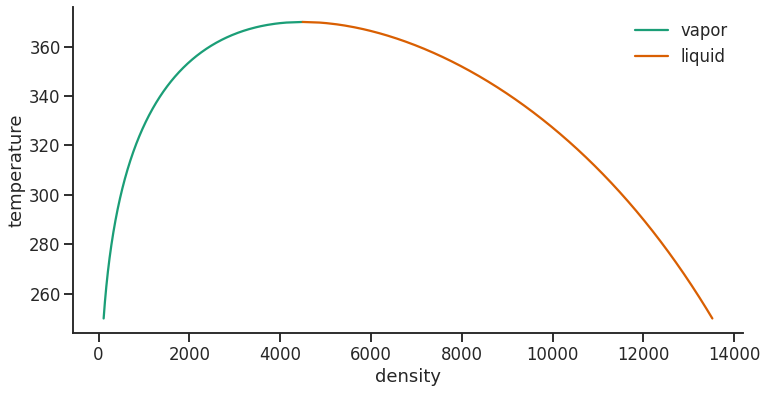

In [21]:
phase_plot(data_dia, "density", "temperature")

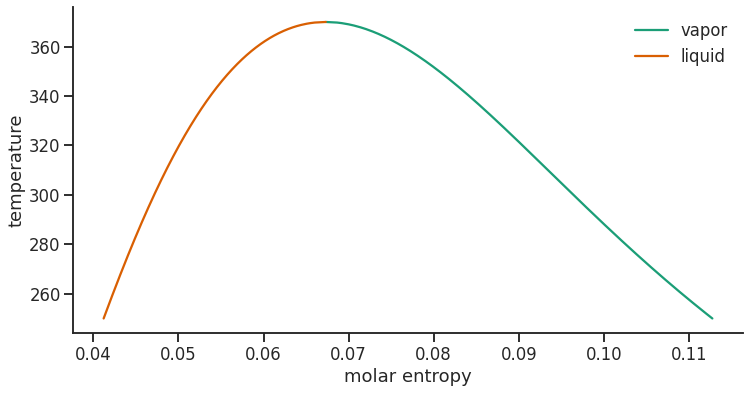

In [22]:
phase_plot(data_dia, "molar entropy", "temperature")

## Mixtures <a id="mix"/>
[↑ Back to top](#toc)

Fox mixtures, we have to add information about the composition, either as molar fraction, amount of substance per component, or as partial densities.

In [23]:
# propane, butane mixture
tc = np.array([369.96, 425.2]) * KELVIN
pc = np.array([4250000.0, 3800000.0]) * PASCAL
omega = np.array([0.153, 0.199])
molar_weight = np.array([44.0962, 58.123]) * GRAM / MOL

eos = UserDefinedEos(PyPengRobinson(tc, pc, omega, molar_weight))

In [24]:
s = State(eos, temperature=300*KELVIN, pressure=1*BAR, molefracs=np.array([0.5, 0.5]), total_moles=MOL)
s

|temperature|density|molefracs
|-|-|-|
|300.00000 K|40.96869  mol/m³|[0.50000, 0.50000]|

As before, we can compute properties by calling methods on the `State` object. Some return vectors or matrices - for example the chemical potential and its derivative w.r.t amount of substance:

In [25]:
s.chemical_potential()

[-15625.347451682397, -12435.866602695123] J/mol

In [26]:
s.dmu_dni() / (KILO * JOULE / MOL**2)

array([[ 4.90827975, -0.10593968],
       [-0.10593968,  4.85467746]])

Phase equilibria are computed from different constructors:

In [27]:
s_cp = State.critical_point(eos, moles=np.array([0.5, 0.5])*MOL)
s_cp

|temperature|density|molefracs
|-|-|-|
|401.65486 K|3.99952 kmol/m³|[0.50000, 0.50000]|

In [28]:
vle = PhaseEquilibrium.bubble_point_tx(eos, 350*KELVIN, liquid_molefracs=np.array([0.5, 0.5]))
vle

||temperature|density|molefracs|
|-|-|-|-|
|phase 1|350.00000 K|879.47505  mol/m³|[0.67625, 0.32375]|
|phase 2|350.00000 K|8.96382 kmol/m³|[0.50000, 0.50000]|


In [29]:
vle = PhaseDiagramBinary.new_pxy(eos, temperature=350*KELVIN, npoints=50)

/tmp/ipykernel_11471/2221081275.py:65: RuntimeWarning: invalid value encountered in log
  return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature)
/tmp/ipykernel_11471/2221081275.py:66: RuntimeWarning: invalid value encountered in log
  * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))


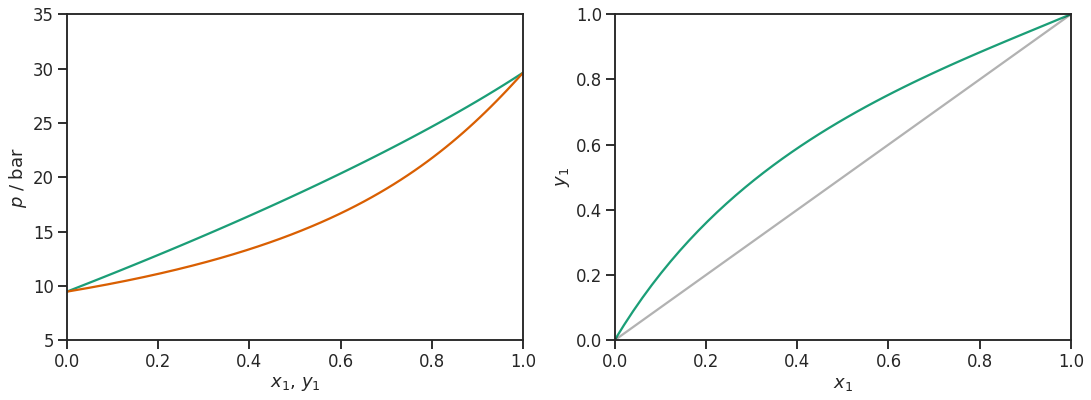

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# fig.title("T = 350 K, Propane (1), Butane (2)")
sns.lineplot(x=vle.liquid_molefracs, y=vle.pressure / BAR, ax=ax[0])
sns.lineplot(x=vle.vapor_molefracs, y=vle.pressure / BAR, ax=ax[0])
ax[0].set_xlabel(r"$x_1$, $y_1$")
ax[0].set_ylabel(r"$p$ / bar")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(5, 35)
# ax[0].legend(frameon=False);

sns.lineplot(x=vle.liquid_molefracs, y=vle.vapor_molefracs, ax=ax[1])
sns.lineplot(x=np.linspace(0, 1, 10), y=np.linspace(0, 1, 10), color="black", alpha=0.3, ax=ax[1])
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$y_1$")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1);

## Comparison to Rust implementation <a id="rust"/>
[↑ Back to top](#toc)

Implementing an equation of state in Python is nice for quick prototyping and development but when it comes to performance, implementing the equation of state in Rust is the way to go.
For each non-cached call to the Helmholtz energy, we have to transition between Rust and Python with our Python implementation which generates quite some overhead.

Here are some comparisons between the Rust and our Pyhton implemenation:

In [31]:
# rust
from feos_core.cubic import PengRobinson, State as StateR, PengRobinsonParameters, PhaseDiagramPure as PhaseDiagramPureR
eos_rust = PengRobinson(PengRobinsonParameters.from_json(["propane"], "peng-robinson.json"))

# python
tc = SIArray1(369.96 * KELVIN)
pc = SIArray1(4250000.0 * PASCAL)
omega = np.array([0.153])
molar_weight = SIArray1(44.0962 * GRAM / MOL)
eos_python = UserDefinedEos(PyPengRobinson(tc, pc, omega, molar_weight))

In [32]:
# let's first test if both actually yield the same results ;)
assert abs(State.critical_point(eos_python).pressure() / BAR - StateR.critical_point(eos_rust).pressure() / BAR) < 1e-13
assert abs(State.critical_point(eos_python).temperature / KELVIN - StateR.critical_point(eos_rust).temperature / KELVIN) < 1e-13

In [33]:
import timeit

time_python = timeit.timeit(lambda: State.critical_point(eos_python), number=2_500) * MILLI * SECOND
time_rust = timeit.timeit(lambda: StateR.critical_point(eos_rust), number=2_500) * MILLI * SECOND

In [34]:
rel_dev = (time_rust - time_python) / time_rust
print(f"Critical point for pure substance")
print(f"Python implementation is {'slower' if rel_dev < 0 else 'faster'} by a factor of {abs(time_python / time_rust):.0f}.")

Critical point for pure substance
Python implementation is slower by a factor of 48.


In [35]:
time_python = timeit.timeit(lambda: PhaseDiagramPure(eos_python, 250*KELVIN, 100), number=100) * MILLI * SECOND
time_rust = timeit.timeit(lambda: PhaseDiagramPureR(eos_rust, 250*KELVIN, 100), number=100) * MILLI * SECOND

/tmp/ipykernel_11471/2221081275.py:65: RuntimeWarning: invalid value encountered in log
  return n * (np.log(v / (v - b * n)) - ak_mix / (b * SQRT2 * 2.0 * state.temperature)
/tmp/ipykernel_11471/2221081275.py:66: RuntimeWarning: invalid value encountered in log
  * np.log((v * (SQRT2 - 1.0) + b * n) / (v * (SQRT2 + 1.0) - b * n)))


In [36]:
rel_dev = (time_rust - time_python) / time_rust
print(f"Phase diagram for pure substance")
print(f"Python implementation is {'slower' if rel_dev < 0 else 'faster'} by a factor of {abs(time_python / time_rust):.0f}.")

Phase diagram for pure substance
Python implementation is slower by a factor of 25.
